# Gaussian Process

フルスクラッチ？（numpy, scipyは使ってよい）  
scikit-learnは以下の文献を参考に実装している。  
C. E. Rasmussen & C. K. I. Williams, Gaussian Processes for Machine Learning, the MIT Press, 2006,

ref)

ガウス過程の基礎と教師なし学習  
https://www.ism.ac.jp/~daichi/lectures/H26-GaussianProcess/gp-lecture2-daichi.pdf

Instruction of chemoinformatics "Gaussian Process"  
https://funatsu-lab.github.io/open-course-ware/machine-learning/gaussian-process/

scikit-learn "Gaussian Processes"  
https://scikit-learn.org/stable/modules/gaussian_process.html#gaussian-process

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from scipy import stats
from scipy.linalg import cholesky, cho_solve, solve_triangular
from scipy.spatial.distance import pdist, cdist, squareform

from sklearn.preprocessing import StandardScaler

plt.style.use('seaborn-darkgrid')

# 1. Data

真の分布を仮定する

In [2]:
def sample(x):
    return x * np.sin(x)

定義域はx = [0, 10]  
その内、4点のみがサンプリングされているとする。

X, yのshapeは(n_samples, n_features [or n_output_dims])である。

In [3]:
x = np.atleast_2d(np.arange(0, 10, 0.1)).T

# Generated sample
x_train = np.atleast_2d([1., 3., 5., 6., 7., 8.]).T
y_train = sample(x_train)

print(x.shape, x_train.shape, y_train.shape)

(100, 1) (6, 1) (6, 1)


スケーリングしたものを、予め用意しておく

In [4]:
scl = StandardScaler()
y_train_scl = scl.fit_transform(y_train)

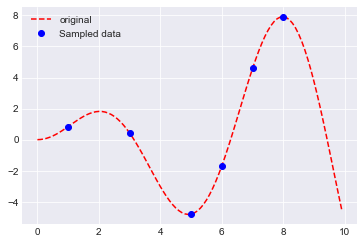

In [5]:
plt.plot(x, sample(x), 'r--', label='original')
plt.plot(x_train, y_train, 'bo', label='Sampled data')
plt.legend()
plt.show()

# 2. Kernel

ref)  

RBF Kernel  
https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/gaussian_process/kernels.py#L1146

White Kernel  
https://github.com/scikit-learn/scikit-learn/blob/55bf5d9/sklearn/gaussian_process/kernels.py#L1049

squared Euclidean distance.
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist

In [6]:
def rbf_kernel(X, Y=None, scale=1.0):
    # RBF kernel
    X = np.atleast_2d(X)
    
    # Computes the Squared Euclidean distance.
    if Y is None:
        dists = pdist(X / scale, metric='sqeuclidean')
        K = np.exp(- .5 * dists)
        # convert from upper-triangular matrix to square matrix
        K = squareform(K)
        np.fill_diagonal(K, 1)
    else:
        dists = cdist(X / scale, Y / scale, metric='sqeuclidean')
        K = np.exp(- .5 * dists)
    return K

In [7]:
def constant_kernel(X, Y=None, constant=1.0):    
    return np.full((X.shape[0], Y.shape[0]), constant)

In [8]:
def kernel(X, Y=None, scale=1.0, constant=1.0):
    return constant_kernel(X, Y) * rbf_kernel(X, Y)

# 3. ガウス分布の平均と分散の更新

## Line 2. カーネルの計算

train: K_nの計算  
test: K_x, K_xxの計算

ノイズ項も付加している

$
K_n = \left(
\begin{array}{ccc}
k_\theta (x_1, x_1) & ... & k_\theta (x_1, x_n) \\
... & ... & ... \\
k_\theta (x_n, x_1) & ... & k_\theta (x_n, x_n)
\end{array}
\right)
$

In [9]:
K_n = kernel(x_train, x_train) + np.eye(x_train.shape[0]) * 1e-10

Cholesky decomposition  
https://en.wikipedia.org/wiki/Cholesky_decomposition

正定値エルミート行列$A$、下三角行列$L$、共役転置$L^*$として、  
$A = LL^*$

Aが実対称行列の場合、  
$A = LL^T$

$L = cholesky(K + \sigma_n^2 I)$

In [10]:
L_ = cholesky(K_n, lower=True)
print(L_)

[[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.35335283e-01 9.90799859e-01 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.35462628e-04 1.36546127e-01 9.90633657e-01 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [3.72665317e-06 1.12116409e-02 6.10719965e-01 7.91767279e-01
  0.00000000e+00 0.00000000e+00]
 [1.52299797e-08 3.38575509e-04 1.36568197e-01 6.60701640e-01
  7.38120828e-01 0.00000000e+00]
 [2.28973485e-11 3.76125414e-06 1.12135126e-02 1.62278650e-01
  6.74390236e-01 7.20234480e-01]]


## Line 3. $\alpha$の計算

yの平均をずらす。今回は予めstandardizationしてあるので、平均0である。

In [11]:
y_mean = np.mean(y_train_scl)
y_train_scl = y_train_scl - y_mean

trainデータだけで計算できるものは、予め計算しておく  
cho_solveでは、$Ax = b$、つまり$L \alpha = y_{train}$を解くので、  
$\alpha = L \backslash y_{train}$が求められる。

In [12]:
alpha_ = cho_solve((L_, True), y_train_scl)
# alpha_ = cho_solve((L_.T, True), alpha_)
print(alpha_)

[[-0.09255281]
 [ 0.01134971]
 [-1.4056755 ]
 [-0.15741792]
 [ 0.15477036]
 [ 1.57063868]]


# 4. 予測

test dataから計算する

$
K_x^T = \left(
\begin{array}{ccc}
k_\theta (x_1, x_{new_1}) & ... & k_\theta (x_1, x_{new_n}) \\
... & ... & ... \\
k_\theta (x_n, x_{new_1}) & ... & k_\theta (x_n, x_{new_n})
\end{array}
\right)
$

In [13]:
K_x = kernel(x, x_train)  # K_trans
K_xx = kernel(x, x)

## Line 4. 平均の予測、予測値を逆変換する

$y_{pred} = K_x^T K_n y_n$

In [14]:
y_pred = K_x.dot(alpha_)
y_pred = y_pred + y_mean  # Undo normal

## Line 5. 標準偏差（1次元）を求める

solve_triangular: solve $a x = b$ for x

つまり、$L^T x = I$, $x = L^{-1}$を計算する

これを用いると、$K^{-1} = L^{-1} (L^{-1})^T$

In [15]:
L_inv = solve_triangular(L_.T, np.eye(L_.shape[0]))
K_inv = L_inv.dot(L_inv.T)

$\sigma^2 = K(x, x) - K(x, x_{1:n})^T K_\theta (x_{1:n})^{-1} K(x, x_{1:n})$

In [16]:
y_std = K_xx.diagonal()
y_std = y_std - np.einsum('ij,ij->i', np.dot(K_x, K_inv), K_x)

In [17]:
y_std_negative = y_std < 0
if np.any(y_std_negative):
    y_std[y_std_negative] = 0.

## プロットする前に、求められた平均と分散のスケールを元に戻す

In [18]:
y_pred = scl.inverse_transform(y_pred)
y_std = y_std.reshape(-1, 1) * scl.scale_

## plot

matplotlib color example  
https://matplotlib.org/examples/color/named_colors.html

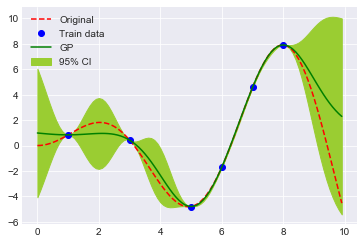

In [19]:
plt.plot(x, sample(x), 'r--', label='Original')
plt.plot(x_train, y_train, 'bo', label='Train data')
plt.plot(x, y_pred, 'g', label='GP')
plt.fill_between(x.squeeze(), (y_pred - 1.96 * y_std).squeeze(),
                 (y_pred + 1.96 * y_std).squeeze(),
                 color='yellowgreen', label='95% CI') 
plt.legend()
plt.show()

# 5. scikit-learnのモデルを使う

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, WhiteKernel

In [21]:
scl = StandardScaler()
y_train_scl = scl.fit_transform(y_train)

kernel = ConstantKernel() * RBF()
gp = GaussianProcessRegressor(kernel=kernel)
gp.fit(x_train, y_train_scl)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * RBF(length_scale=1), n_restarts_optimizer=0,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [22]:
pred_mu, pred_sg = gp.predict(x, return_std=True)
pred_mu = scl.inverse_transform(pred_mu)
pred_sg = pred_sg.reshape(-1, 1) * scl.scale_

凡そ同じ結果が得られた。

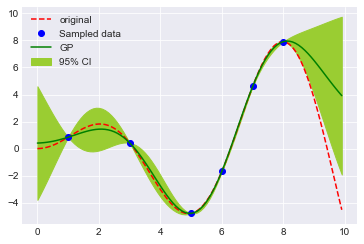

In [23]:
plt.plot(x, sample(x), 'r--', label='original')
plt.plot(x_train, y_train, 'bo', label='Sampled data')
plt.plot(x, pred_mu, 'g', label='GP')
plt.fill_between(x.squeeze(), (pred_mu - 1.96 * pred_sg).squeeze(),
                 (pred_mu + 1.96 * pred_sg).squeeze(),
                 color='yellowgreen', label='95% CI') 
plt.legend()
plt.show()